In [1]:
#!wget https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0730_MEASURES_MOA2014_v01/geotiff/moa750_2014_hp1_v01.tif

In [1]:
! pip install cmasher

DEPRECATION: Loading egg at /home/jovyan/.local/lib/python3.11/site-packages/tf_unet-0.1.2-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached cmasher-1.8.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached colorspacious-1.1.2-py2.py3-none-any.whl.metadata (3.6 kB)
Using cached cmasher-1.8.0-py3-none-any.whl (533 kB)
Using cached colorspacious-1.1.2-py2.py3-none-any.whl (37 kB)


In [2]:
import pandas as pd
import numpy as np
import os, sys

import rasterio, rioxarray
from rasterio.plot import show

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.path as mpath

import cartopy
import cartopy.crs as ccrs
import cmasher as cm

folder_path = '/home/jovyan/' 
sys.path.append(folder_path)
import useful_fx

In [3]:
moa = 'moa750_2014_hp1_v01.tif'

In [4]:
moa_da = rioxarray.open_rasterio(moa)
moa_ds = moa_da.to_dataset('band')
moa_ds

<xarray.Dataset> Size: 112MB
Dimensions:      (y: 6964, x: 8056)
Coordinates:
  * x            (x) float64 64kB -3.174e+06 -3.173e+06 ... 2.866e+06 2.867e+06
  * y            (y) float64 56kB 2.406e+06 2.405e+06 ... -2.816e+06 -2.816e+06
    spatial_ref  int64 8B 0
Data variables:
    1            (y, x) uint16 112MB ...
Attributes:
    AREA_OR_POINT:        Area
    TIFFTAG_XRESOLUTION:  1
    TIFFTAG_YRESOLUTION:  1
    scale_factor:         1.0
    add_offset:           0.0

In [5]:
berg_base = pd.read_csv('largest_annual_iceberg_NICBYU_manual_validation_lat_lon.csv')
berg_base = berg_base.sort_values(by='Area', ascending=False)

In [6]:
df = berg_base
df['File_Name'] = df['File_Name'].str.upper()

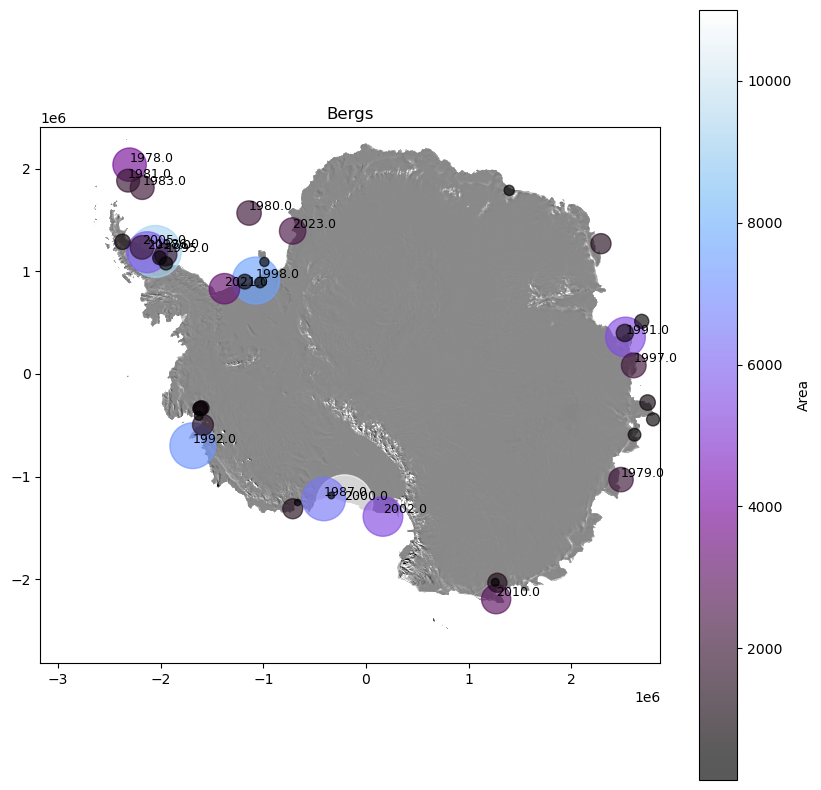

In [7]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.nic_2, df.nic_1))
gdf.crs = "EPSG:4326"

with rasterio.open(moa) as tif:
    # Plot the TIFF as a background
    fig, ax = plt.subplots(figsize=(10, 10))
    show(tif, ax=ax, cmap='gist_yarg', vmin=1e4, vmax=2.3e4)
    
    # Reproject the GeoDataFrame to the TIFF's CRS for accurate overlay
    gdf_reprojected = gdf.to_crs(tif.crs)
    
    # Convert marker sizes and colors based on 'Area'
    marker_sizes = gdf_reprojected['Area'] * 0.15
    colors = gdf_reprojected['Area']  # Here, we'll use Area directly as color

    # Create a scatter plot for the GeoDataFrame points
    scatter = ax.scatter(gdf_reprojected.geometry.x, gdf_reprojected.geometry.y, s=marker_sizes, c=colors, cmap=cm.voltage, alpha=0.65)
    
    # Add text labels for 'File_Name' where 'Area' > 6000
    for idx, row in gdf_reprojected.iterrows():
        if row['Area'] > 1700:
            ax.text(row.geometry.x, row.geometry.y, str(row['Year']), verticalalignment='bottom', fontsize=9)

    ax.set_title("Bergs")
    
    # Create a colorbar
    fig.colorbar(scatter, ax=ax, label='Area')

plt.show()


NameError: name 'cropped_cmap' is not defined

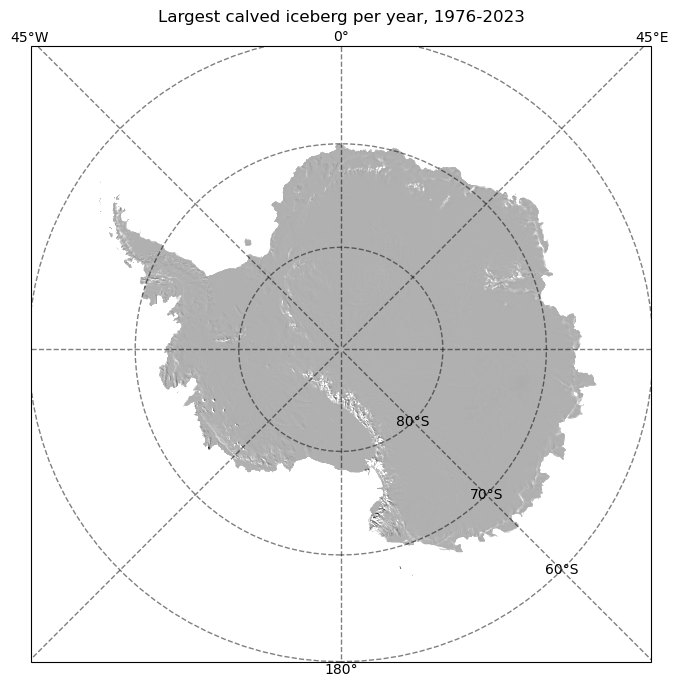

In [8]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.nic_2, df.nic_1))
gdf.crs = "EPSG:4326"

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.SouthPolarStereo()})
#ax.add_feature(cartopy.feature.COASTLINE)

# add title
ax.set_title("Largest calved iceberg per year, 1976-2023")

# Load and plot MODIS MOA
with rasterio.open(moa) as tif:
    ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
    show(tif, ax=ax, transform=ccrs.PlateCarree(), cmap='gist_yarg', vmin=1.15e4, vmax=2.6e4)

# Add lines of longitude and latitude
gl = ax.gridlines(draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlocator = ticker.FixedLocator([-180, -135, -90, -45, 0, 45, 90, 135])
gl.ylocator = ticker.FixedLocator([-80, -70, -60])

# Attempt to make bottom labels horizontal
gl.xlabel_style = {'rotation': 0, 'ha': 'center'}  
ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())


# Reproject the GeoDataFrame to the TIFF's CRS for accurate overlay
gdf_reprojected = gdf.to_crs(tif.crs)

# Convert marker sizes and colors based on 'Area'
marker_sizes = gdf_reprojected['Area'] * 0.2
colors = gdf_reprojected['Area']  # Here, we'll use Area directly as color

# Create a scatter plot for the GeoDataFrame points
scatter = ax.scatter(gdf_reprojected.geometry.x, gdf_reprojected.geometry.y, s=marker_sizes, c=colors, 
                     cmap=cropped_cmap, norm = 'symlog', alpha=0.65)

# Add text labels for 'File_Name' where 'Area' > 6000
for idx, row in gdf_reprojected.iterrows():
    if row['Area'] > 5700:
        ax.text(row.geometry.x, row.geometry.y, str(row['File_Name']), verticalalignment='bottom', fontsize=14)



# plot the image within a circle, not square
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#plt.savefig('iceberg_map.svg',dpi=230)
plt.show()

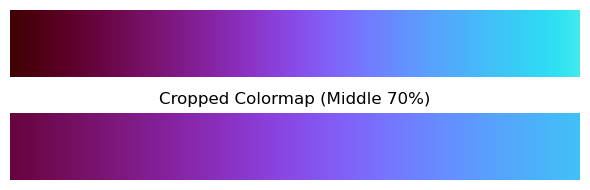

In [9]:
orig_cmap = cm.gem

# Cropped colormap (middle 70% of the original colormap)
cropped_cmap = useful_fx.crop_colormap(orig_cmap, 0.15, 0.85)

# Test the new colormap
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, axes = plt.subplots(nrows=2, figsize=(6, 2), dpi=100)
axes[0].imshow(gradient, aspect='auto', cmap=orig_cmap)
axes[1].imshow(gradient, aspect='auto', cmap=cropped_cmap)
axes[1].set_title('Cropped Colormap (Middle 70%)')
for ax in axes:
    ax.set_axis_off()
plt.tight_layout()
plt.show()


In [10]:
#len((df.Date).dropna())
#berg_base.sort_values(by='Year', ascending=False)

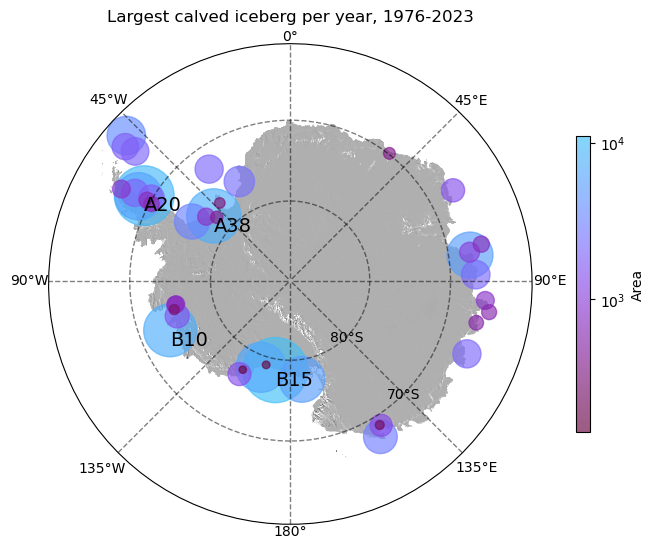

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.path as mpath

# Assuming 'gdf', 'moa', and your mapping code is already correctly defined and imported as necessary

# Plotting starts here
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# Setup color normalization and colormap
norm = mcolors.SymLogNorm(linthresh=1, linscale=1, base=10, vmin=gdf['Area'].min(), vmax=gdf['Area'].max())
cmap = cropped_cmap  # Use a grayscale colormap

# Reproject and plot GeoDataFrame as earlier
with rasterio.open(moa) as tif:
    gdf_reprojected = gdf.to_crs(tif.crs)
    marker_sizes = gdf_reprojected['Area'] * 0.2
    scatter = ax.scatter(gdf_reprojected.geometry.x, gdf_reprojected.geometry.y, s=marker_sizes, c=gdf_reprojected['Area'],
                         cmap=cmap, norm=norm, alpha=0.65)
    ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
    show(tif, ax=ax, transform=ccrs.PlateCarree(), cmap='gist_yarg', vmin=1.05e4, vmax=2.8e4)

# Create a colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.48, pad=0.07)
cbar.set_label('Area')


# Rest of your plotting code
ax.set_title("Largest calved iceberg per year, 1976-2023")
ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlocator = ticker.FixedLocator([-180, -135, -90, -45, 0, 45, 90, 135])
gl.ylocator = ticker.FixedLocator([-80, -70, -60])
gl.xlabel_style = {'rotation': 0, 'ha': 'center'}


for idx, row in gdf_reprojected.iterrows():
    if row['Area'] > 6700:
        ax.text(row.geometry.x, row.geometry.y, str(row['File_Name']), verticalalignment='top', fontsize=14)

# Modify plot boundary to be a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('iceberg_map.pdf',dpi=330)
plt.show()